<a href="https://colab.research.google.com/github/lowbee2019/Files/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

# MNIST

In [1]:
import keras
from keras.layers import *
from keras.datasets.mnist import load_data
from matplotlib import pyplot
import numpy as np

11501568/11490434 [==============================] - 0s 0us/step


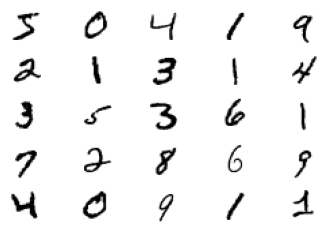

In [2]:
(trainX,trainy),(testX,testy) = load_data()
for i in range(25):
  pyplot.subplot(5,5,i+1)
  pyplot.axis('off')
  pyplot.imshow(trainX[i],cmap="gray_r")
pyplot.show()

# Discriminator

## define

In [3]:
def discriminator(in_shape=(28,28,1)):
  model = keras.models.Sequential()
  model.add(Conv2D(64,(3,3),strides=(2,2),padding='same',input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))

  opt = keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
  return model

In [4]:
Disc = discriminator()
Disc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

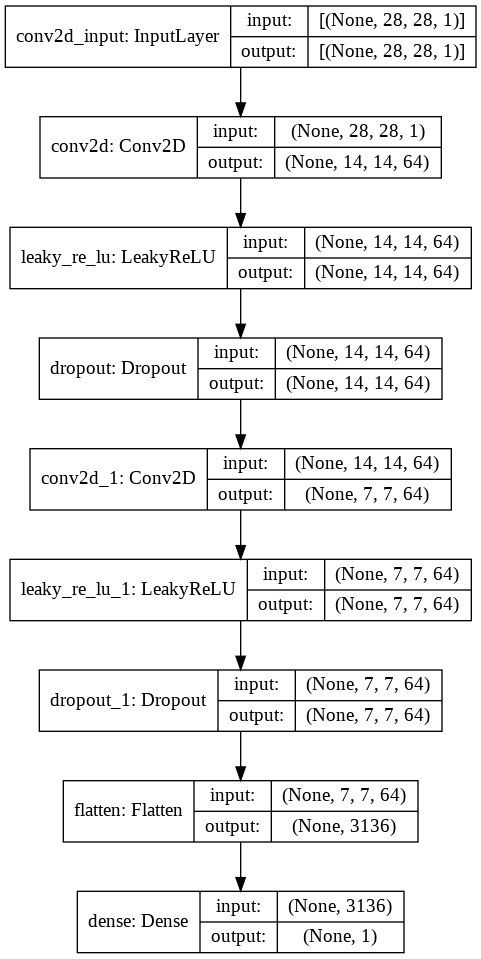

In [5]:
from keras.utils.vis_utils import plot_model
plot_model(Disc,to_file="discriminator.png",show_shapes=True,show_layer_names=True)

## prepare train samples

In [6]:
def load_real_samples():
  (trainX,_),(_,_) = load_data()
  X = np.expand_dims(trainX,axis=-1)
  X = X.astype('float32')
  X = X/255.0
  return X

In [7]:
# 训练过程需要随机输入
def generate_real_samples(dataset,n_samples):
  ix = np.random.randint(0,dataset.shape[0],n_samples)
  X = dataset[ix]
  # 这些是真实图片，因此label设置成1
  y = np.ones((n_samples,1))
  return X,y

In [8]:
#产生fake样本
def generate_fake_samples(n_samples):
  X = np.random.rand(28*28*n_samples)
  X = X.reshape((n_samples,28,28,1))
  #这些事假图片，因此label为0
  y = np.zeros((n_samples,1))
  return X,y

## train

In [9]:
#这个地方训练不需要混合一下吗
def train_discriminator(model,dataset,n_iter=100,n_batch=256):
  half_batch = int(n_batch/2)
  for i in range(n_iter):
    X_real,y_real = generate_real_samples(dataset,half_batch)
    _,real_acc = model.train_on_batch(X_real,y_real)
    X_fake,y_fake = generate_fake_samples(half_batch)
    _,fake_acc = model.train_on_batch(X_fake,y_fake)
    print("Epoch {0}: real={1}% fake={2}%".format(i+1,real_acc*100,fake_acc*100))

In [10]:
dataset = load_real_samples()
train_discriminator(Disc,dataset)

Epoch 1: real=35.9375% fake=47.65625%
Epoch 2: real=50.0% fake=60.9375%
Epoch 3: real=41.40625% fake=82.8125%
Epoch 4: real=53.90625% fake=92.96875%
Epoch 5: real=50.0% fake=97.65625%
Epoch 6: real=46.09375% fake=97.65625%
Epoch 7: real=50.0% fake=100.0%
Epoch 8: real=48.4375% fake=100.0%
Epoch 9: real=42.96875% fake=100.0%
Epoch 10: real=51.5625% fake=100.0%
Epoch 11: real=46.875% fake=100.0%
Epoch 12: real=53.90625% fake=100.0%
Epoch 13: real=56.25% fake=100.0%
Epoch 14: real=57.8125% fake=100.0%
Epoch 15: real=60.15625% fake=100.0%
Epoch 16: real=64.0625% fake=100.0%
Epoch 17: real=62.5% fake=100.0%
Epoch 18: real=70.3125% fake=100.0%
Epoch 19: real=65.625% fake=100.0%
Epoch 20: real=71.875% fake=100.0%
Epoch 21: real=76.5625% fake=100.0%
Epoch 22: real=80.46875% fake=100.0%
Epoch 23: real=79.6875% fake=100.0%
Epoch 24: real=85.15625% fake=100.0%
Epoch 25: real=87.5% fake=100.0%
Epoch 26: real=91.40625% fake=100.0%
Epoch 27: real=92.96875% fake=100.0%
Epoch 28: real=96.09375% fake=1

# Generator

## define

In [11]:
def generator(latent_dim):
  model=keras.models.Sequential()
  n_nodes = 128*7*7
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128)))
  # 上采样为14*14
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # 上采样为28*28
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1,(7,7),activation='sigmoid',padding='same'))
  return model

In [12]:
latent_dim =100
Gene = generator(latent_dim)
Gene.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

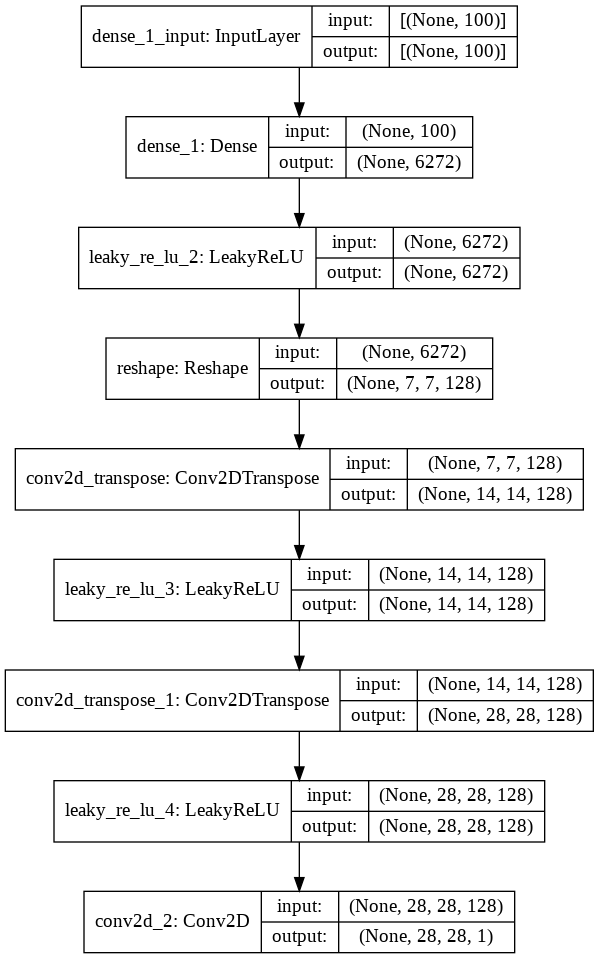

In [13]:
plot_model(Gene,to_file='generator.png',show_shapes=True,show_layer_names=True)

## generate fake samples

In [14]:
# seeds for fake samples
def generate_latent_points(latent_dim,n_samples):
  x_input = np.random.randn(latent_dim*n_samples)
  X_input = x_input.reshape(n_samples,latent_dim)
  return X_input

In [15]:
def generate_fake_samples(model,latent_dim,n_samples):
  x_input = generate_latent_points(latent_dim,n_samples)
  X = model.predict(x_input)
  y = np.zeros((n_samples,1))
  return X,y

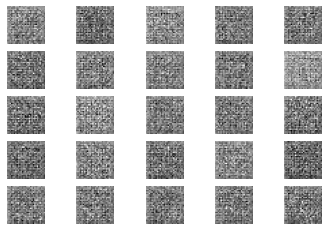

In [16]:
X,_ = generate_fake_samples(Gene,latent_dim,n_samples=25)
for i in range(25):
  pyplot.subplot(5,5,i+1)
  pyplot.axis('off')
  pyplot.imshow(X[i,:,:,0],cmap="gray_r")
pyplot.show()

## train

In [17]:
def GAN(g_model,d_model):
  d_model.trainable=False
  model = keras.models.Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


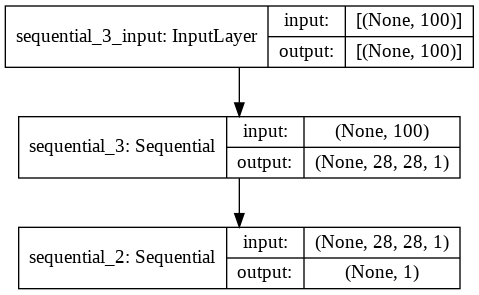

In [18]:
latent_dim=100
d_model = discriminator()
g_model = generator(latent_dim=100)
gan_model = GAN(g_model,d_model)
gan_model.summary()
plot_model(gan_model,to_file="gan.png",show_shapes=True,show_layer_names=True)

In [19]:
def train_GAN(gan_model,latent_dim,n_epochs=100,n_batch=256):
  for i in range(n_epochs):
    x_gan = generate_latent_points(latent_dim,n_batch)
    y_gan = np.ones((n_batch,1))
    gan_model.train_on_batch(x_gan,y_gan)

# Train GAN

In [31]:
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=100):
  X_real,y_real = generate_real_samples(dataset,n_samples)
  _,acc_real = d_model.evaluate(X_real,y_real,verbose=0)
  X_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
  _,acc_fake = d_model.evaluate(X_fake,y_fake,verbose=0)
  print('Epoch %d:>Accuracy real: %.0f%%,fake: %.0f%%'%(epoch,acc_real*100,acc_fake*100))

In [27]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=50,n_batch=512):
  batch_per_epochs = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(batch_per_epochs):
      X_real,y_real = generate_real_samples(dataset,half_batch)
      X_fake,y_fake = generate_fake_samples(g_model,latent_dim,half_batch)
      X,y = np.vstack((X_real,X_fake)),np.vstack((y_real,y_fake))
      d_loss,_=d_model.train_on_batch(X,y)
      X_gan = generate_latent_points(latent_dim,n_batch)
      y_gan = np.ones((n_batch,1))
      g_loss = gan_model.train_on_batch(X_gan,y_gan)
      # print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # if (i+1)%10==0:
    summarize_performance(i,g_model,d_model,dataset,latent_dim)

In [28]:
train(g_model,d_model,gan_model,dataset,latent_dim)

>Accuracy real: 71%,fake: 32%
>Accuracy real: 63%,fake: 31%
>Accuracy real: 81%,fake: 59%
>Accuracy real: 79%,fake: 19%
>Accuracy real: 85%,fake: 13%
>Accuracy real: 82%,fake: 40%
>Accuracy real: 35%,fake: 72%
>Accuracy real: 75%,fake: 50%
>Accuracy real: 86%,fake: 40%
>Accuracy real: 70%,fake: 70%
>Accuracy real: 88%,fake: 19%
>Accuracy real: 92%,fake: 26%
>Accuracy real: 72%,fake: 59%
>Accuracy real: 71%,fake: 33%
>Accuracy real: 96%,fake: 36%
>Accuracy real: 94%,fake: 30%
>Accuracy real: 83%,fake: 57%
>Accuracy real: 97%,fake: 21%
>Accuracy real: 75%,fake: 40%
>Accuracy real: 80%,fake: 48%
>Accuracy real: 93%,fake: 12%
>Accuracy real: 71%,fake: 65%
>Accuracy real: 71%,fake: 47%
>Accuracy real: 37%,fake: 81%
>Accuracy real: 82%,fake: 31%
>Accuracy real: 86%,fake: 15%
>Accuracy real: 92%,fake: 13%
>Accuracy real: 68%,fake: 70%
>Accuracy real: 90%,fake: 30%
>Accuracy real: 19%,fake: 100%
>Accuracy real: 77%,fake: 32%
>Accuracy real: 99%,fake: 10%
>Accuracy real: 87%,fake: 32%
>Accuracy

# Generate Images

In [29]:
def save_plot(examples,n):
  for i in range(n*n):
    pyplot.subplot(n,n,i+1)
    pyplot.axis('off')
    pyplot.imshow(examples[i,:,:,0],cmap="gray_r")
  pyplot.show()

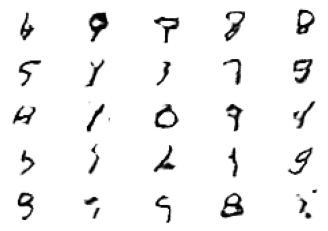

In [43]:
latent_points = generate_latent_points(100,25)
X = g_model.predict(latent_points)
save_plot(X,5)

In [44]:
g_model.save("generator_50.h5")